In [1]:
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import xarray as xr
import gsw
import metpy
from pathlib import Path
import cartopy.crs as ccrs
import geopy.distance
import mplniw.utils as ut
import mplniw.sigp as sp
import matplotlib.gridspec as gridspec

import gvpy as gv

import niskine

In [2]:
mooring = 3
conf = niskine.io.load_config()
lon, lat, bottom_depth = niskine.io.mooring_location(mooring=mooring)
root_dir = '/Users/zcasparcohen/codes/NIW/data/'

In [4]:
#Definition filter
Tw = 30  # Kernel length
#omega = 2.0 
omega = ut.coriolis(lat)*3600*24/(2*np.pi)  # Central frequency
#bandwidth = None 
bandwidth = 0.2
dt = 1/(24*6)  # Time step in days unit
h = ut.generate_filter(omega,dt=dt,T=Tw,bandwidth=bandwidth,lat=lat,pass_zero=False)  # Best filter
h_hat, w = ut.filter_response(h, dt=dt)  #Filter response

In [5]:
import mplniw.sigp as sp
gridded=xr.open_dataset(root_dir+'M%s_linear_merge_slinearfill.nc'%mooring)[['u','v']]
ds = sp.wrap_filter(gridded,h,**{'hilbert':False})

In [6]:
mld_m1 = xr.open_dataarray(conf.data.ml.mld).sel(time=slice(ds.time[0],ds.time[-1]))
ds['mld'] = mld_m1
wkb = niskine.clim.get_wkb_factors(gridded)
ds['bpu_wkb'] = ds['u_filtered']*wkb
ds['bpv_wkb'] = ds['v_filtered']*wkb
#ds.bp_eke.attrs.update({'long_name':'Kinetic energy', 'units':r'$m^2.s^{-2}$'})
ds.bpu_wkb.attrs.update({'long_name':'Zonal velocity', 'units':r'$m.s^{-1}$'})
ds.bpv_wkb.attrs.update({'long_name':'Meridional velocity', 'units':r'$m.s^{-1}$'})
#ds['bp_eke'] = ds.bp_eke.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
ds['bpu_wkb'] = ds.bpu_wkb.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
ds['bpv_wkb'] = ds.bpv_wkb.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
ds['u_filtered'] = ds.u_filtered.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
ds['v_filtered'] = ds.v_filtered.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)

In [7]:
ds['ni_ke_wkb'] = 0.5*(ds.bpu_wkb**2+ds.bpv_wkb**2)
ds['ni_ke'] = 0.5*(ds.u_filtered**2+ds.v_filtered**2)

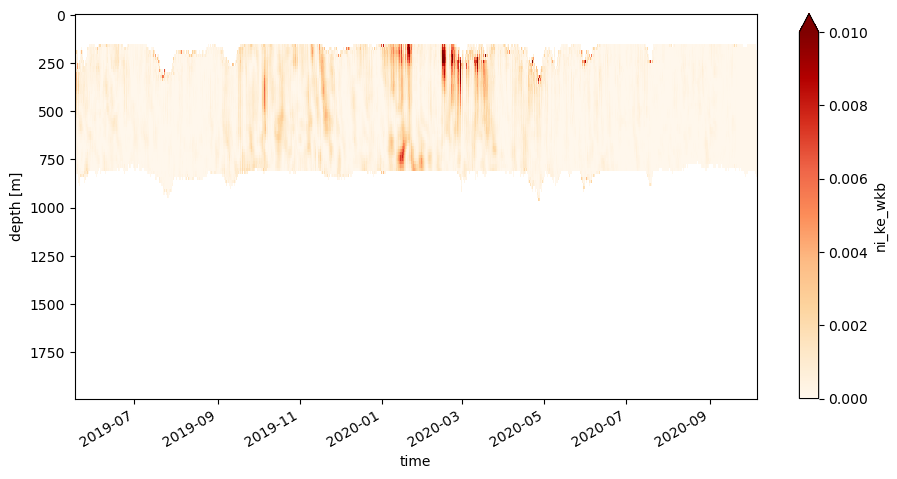

In [8]:
fig,ax = plt.subplots(figsize=(11,5))
ds.ni_ke_wkb.plot(yincrease=False,cmap='OrRd',vmax=0.01)

In [9]:
ds.to_netcdf(root_dir+'NI02_M%s.nc'%mooring)